# PyTorch训练逻辑回归模型，完成手写数字分类任务
在这个notebook中，我们介绍用PyTorch训练一个模型的基本流程：
* 构建数据集
* 构建模型
* 定义损失函数以及优化算法进行训练。

## 构建数据集

对于数据驱动的方法，我们需要大量的数据来训练模型，并在网络没有见过的验证集上验证其性能。PyTorch为我们提供了自己定义数据集的方法。对于一个PyTorch数据集来说，我们需要给它数据集文件的信息，并重写一些方法来让它读取到文件，从而满足训练和验证的需求。

在当前的notebook中，我们接入了一个简单的mnist数据集，包含了7k个训练样本，3k个测试样本。文件为表格形式，形式如下：

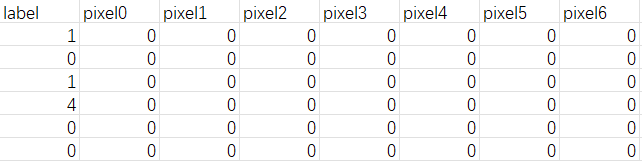

label表示这个数字是几，每个pixel的整数值在（0-255）之间不等，表示该像素的灰度值。由于每个图片大小为28\*28，总共有784个像素（pixel0-pixel783）

在具体的实现过程中，我们需要重写一些方法：
+ 构造函数 \_\_init__
+ 某一个样本的选取 \_\_getitem__
+ 数据集的样本个数 \_\_len__

注意：此处需要同学们根据自己上传的数据集文件位置，更改文件路径`train_data_path`,`val_data_path`

Length of train split: 7000
Length of val split: 3000

The first sample of train split looks like: img_shape is torch.Size([784]), digit is 1


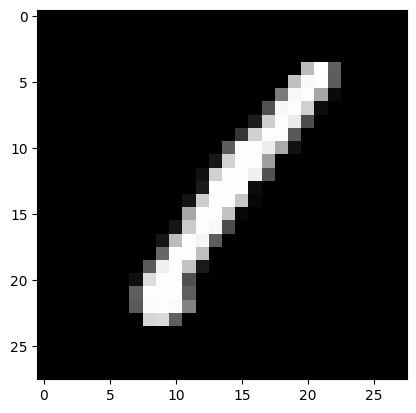

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class Mnist(Dataset):
    def __init__(self, path):
        self.data = pd.read_csv(path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = torch.tensor(self.data.iloc[idx, 0], dtype=torch.long)
        image = torch.tensor(self.data.iloc[idx, 1:].values, dtype=torch.float32)
        image /= 255.0

        return image, label
    
train_data_path = '/Users/a111/Documents/deeplerning/homework/dlec1/train.csv'
val_data_path = '/Users/a111/Documents/deeplerning/homework/dlec1/val.csv'
dataset_train = Mnist(train_data_path)
dataset_val = Mnist(val_data_path)
print(f'Length of train split: {len(dataset_train)}')
print(f'Length of val split: {len(dataset_val)}')
print(f'\nThe first sample of train split looks like: \
img_shape is {dataset_train[0][0].shape}, digit is {dataset_train[0][1]}')

import matplotlib.pyplot as plt
plt.imshow(dataset_train[0][0].view(28, 28), cmap='gray')
plt.show()

注意上面代码中的:
*image /= 255.0*

这一步我们将0-255的整数灰度值归一化到0-1之间的小数。这对网络训练的稳定性是非常重要的。

## 构建一个模型
我们的目标是定义一个简单的模型，用于逻辑回归。

In [5]:
import torch.nn as nn
nn.Module

torch.nn.modules.module.Module

nn.Module是所有神经网络模块的基类，PyTorch为我们提供了许多实现好的层。例如：
* 全连接层（线性层）: nn.Linear
* 卷积层: nn.Conv2d
* 激活层: nn.ReLU, nn.Softmax

这些层都继承自基类nn.Module，这里我们只用到线性层。

我们以全连接层（线性层）nn.Linear为例说明nn.Module的使用方法，首先我们定义一个简单的全连接层。该层将通道数为2的张量转换为通道数为3的张量。

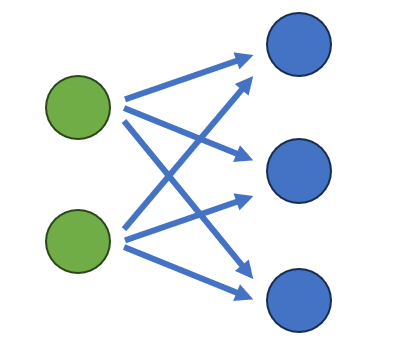

In [6]:
import torch
import torch.nn as nn

simple_lin_layer = nn.Linear(2, 3)
x = torch.randn((10, 2))
y = simple_lin_layer(x)
y.shape

torch.Size([10, 3])

一般情况下，我们需要新建一个类继承nn.Module。这个新建的类是我们需要使用的网络。我们在构造器中定义一系列层，在forward函数中定义该网络的前向传播过程。

In [7]:
import torch
import torch.nn as nn

class MyLinearModel(nn.Module):

    def __init__(self):
        super().__init__()
        # 定义网络中有哪些层
        self.lin1 = nn.Linear(3, 20)
        
    def forward(self, x):
        # 重写nn.Module中的forward方法
        # forward方法表示网络的前向传播过程
        x = self.lin1(x)
        return x
    
network = MyLinearModel()
rand_input = torch.randn((1000, 3))
output = network(rand_input)
print(f'The shape of the output is {output.shape}')

The shape of the output is torch.Size([1000, 20])


## 模型训练

如下图所示，一个模型的训练包含了三个组成部分：
+ 定义模型，这个我们前面介绍了。
+ 定义损失函数（分类中使用的交叉熵、回归使用的MSE、……）
+ 定义优化算法（随机梯度下降SGD、……）

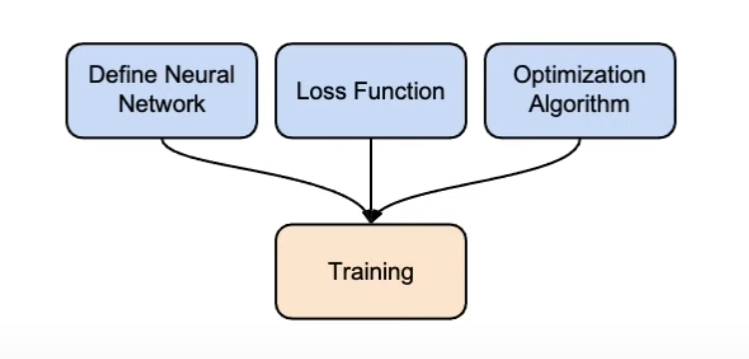

接下来我们给出代码，来展示如何在mnist的训练集上训练我们的逻辑回归模型。

注意：此处同学们可以自行设置模型保存参数文件路径`model_save_path`

In [13]:
import torch
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Linear(784, 10)

    def forward(self, x):
        x = self.layer(x)
        return x

class Mnist(Dataset):
    def __init__(self, path):
        self.data = pd.read_csv(path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = torch.tensor(self.data.iloc[idx, 0], dtype=torch.long)
        image = torch.tensor(self.data.iloc[idx, 1:].values, dtype=torch.float32)
        image /= 255.0

        return image, label

# 定义模型
model = LogReg()
# 该方法让模型进入训练模式（参数）；与之相对的是model.eval()；
# 由于一些层（BN，Dropout）在训练和推理时的行为不同，需要做出区分，这里的网络不含这些层。
model.train()

# 一些训练中的超参数
num_epochs = 30
batch_size = 256
lr = 0.5

# 定义数据集
dataset = Mnist(train_data_path)
# 定义Dataloader。这个类帮助我们把数据集的定义和数据集的加载分离，具体作用是：
# 1. 在每一个epoch前帮我们打乱数据集
# 2. 在训练过程中每次抽取出一个batch的样本量
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 定义优化器
optimizer = optim.SGD(model.parameters(), lr=lr)

# 定义损失函数
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dataloader):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

    # Print statistics
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Step [{i + 1}/{len(dataset) // batch_size}], '
          f'Loss: {loss.item():.4f}'
          )

model_save_path = '/Users/a111/Documents/deeplerning/homework/dlec1/model.pth'
torch.save(model.state_dict(), model_save_path)

Epoch [1/30], Step [28/27], Loss: 0.5936
Epoch [2/30], Step [28/27], Loss: 0.4828
Epoch [3/30], Step [28/27], Loss: 0.6221
Epoch [4/30], Step [28/27], Loss: 0.3932
Epoch [5/30], Step [28/27], Loss: 0.3560
Epoch [6/30], Step [28/27], Loss: 0.3900
Epoch [7/30], Step [28/27], Loss: 0.2396
Epoch [8/30], Step [28/27], Loss: 0.3088
Epoch [9/30], Step [28/27], Loss: 0.3758
Epoch [10/30], Step [28/27], Loss: 0.1705
Epoch [11/30], Step [28/27], Loss: 0.1848
Epoch [12/30], Step [28/27], Loss: 0.2336
Epoch [13/30], Step [28/27], Loss: 0.2901
Epoch [14/30], Step [28/27], Loss: 0.3687
Epoch [15/30], Step [28/27], Loss: 0.3369
Epoch [16/30], Step [28/27], Loss: 0.2693
Epoch [17/30], Step [28/27], Loss: 0.2806
Epoch [18/30], Step [28/27], Loss: 0.2736
Epoch [19/30], Step [28/27], Loss: 0.1756
Epoch [20/30], Step [28/27], Loss: 0.1331
Epoch [21/30], Step [28/27], Loss: 0.1931
Epoch [22/30], Step [28/27], Loss: 0.2369
Epoch [23/30], Step [28/27], Loss: 0.3164
Epoch [24/30], Step [28/27], Loss: 0.1545
E

训练过程中loss会有波动，但整体上逐渐降低。在上面的代码运行完成后，我们注意到kaggle右边面板的ouput中，存了一个model.pth文件。这个文件包含了我们模型的权重，是训练得到的结果。我们接下来用这个文件在验证集上测试它的性能：

Accuracy: 91.03%
The third sample of val split looks like:


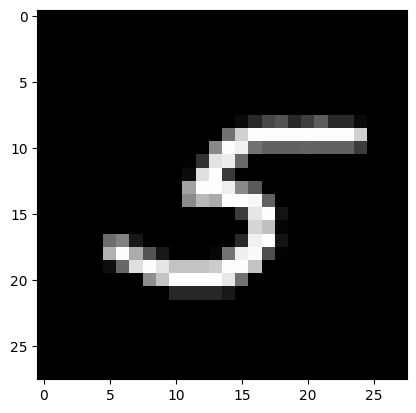

The predicted digit is 5


In [14]:
# Load the trained weights
model.load_state_dict(torch.load(model_save_path, weights_only=True))
model.eval()  # Set the model to evaluation mode
# val split
dataset = Mnist(val_data_path)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)


# Inference loop
predictions = []
all_labels = []
# 我们从验证数据集中一个一个选取样本
with torch.no_grad():
    for images, labels in dataloader:
#       将样本输入到网络中做前向传播，同时由于是分类，因此使用softmax对网络最后一层输出处理
#       注意，训练时没有使用softmax，是因为nn.CrossEntropyLoss会帮我们默认计算softmax
        outputs = model(images).softmax(-1)
#       选取概率最大的作为模型的预测数字
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.tolist())
        all_labels.extend(labels.tolist())

predictions = torch.tensor(predictions)
all_labels = torch.tensor(all_labels)

# 计算正确率，预测对的数量 / 样本总数
print("Accuracy: %s%%" % round((((predictions==all_labels).sum()/len(predictions)).item()*100), 2))

print(f'The third sample of val split looks like:')
import matplotlib.pyplot as plt
plt.imshow(dataset[2][0].view(28, 28), cmap='gray')
plt.show()
print(f'The predicted digit is {predictions[2]}')

助教训练出的准确率大概有90%，同学们可以尝试调整training部分的超参数（epoch数、batch大小、学习率、。。），来让准确率更高一些。这一部分不计分。